In [ ]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
)
from ripple_heterogeneity.readout import pairwise_ccgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
d:\github\nelpy\nelpy\plotting\utils.py:260: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [ ]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


In [87]:
from ripple_heterogeneity.place_cells import maps
basepath = r"Z:\Data\HMC1\day12"

epochs, epoch_df = pairwise_ccgs.get_epochs(basepath)

position_df = loading.load_animal_behavior(basepath)
bad_idx = np.isnan(position_df.x)
position_df = position_df[~bad_idx]

pos = nel.AnalogSignalArray(
    data=np.array(position_df[["x","y"]].values.T),
    timestamps=position_df.time.values,
    step=position_df.sr.iloc[0],
    fs=position_df.sr.iloc[0],
)
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1"
)
spatial_maps = maps.SpatialMap(pos[epochs[1]],st,dim=2)

In [92]:
st

<SpikeTrainArray at 0x191449d8280: 93 units> at 20000 Hz

In [91]:
spatial_maps.tc.ratemap.shape

(93, 76, 20)

In [96]:
map1 = spatial_maps.tc.ratemap[0]
map2 = spatial_maps.tc.ratemap[1]

map1[np.isnan(map1)] = 0
map2[np.isnan(map2)] = 0

In [106]:
spatial_corr = np.corrcoef(spatial_maps.tc.ratemap[0].flatten(),spatial_maps.tc.ratemap[1].flatten())[0,1]
spatial_corr

0.36563832127619833

In [101]:
np.square(np.subtract(map1, map2)).mean()

0.40135204076132225

<AxesSubplot:>

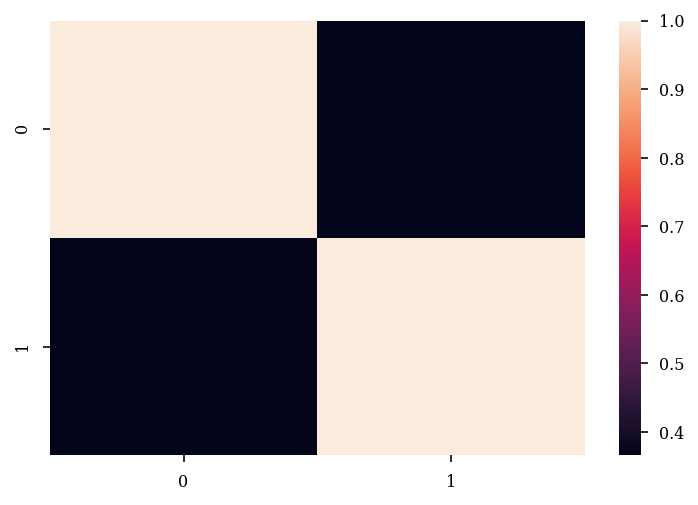

In [100]:
sns.heatmap(np.corrcoef(spatial_maps.tc.ratemap[0].ravel(),spatial_maps.tc.ratemap[1].ravel()))

In [124]:
from itertools import combinations

def pairwise_spatial_corr(X, return_index=False, pairs=None):
    """
    Compute pairwise spatial correlations between cells
    Input:
        X: numpy array of shape (n_cells, n_space, n_space)
        return_index: bool, return the index of the cells used for the correlation
        pairs: list of pairs of cells to compute the correlation
    Output:
        spatial_corr: the pearson correlation between the cells in pairs
        pairs: list of pairs of cells used for the correlation
    
    """
    # Get unique combo without repeats
    if pairs is None:
        x = np.arange(0, X.shape[0])
        pairs = np.array(list(combinations(x, 2)))

    X[np.isnan(X)] = 0

    spatial_corr = []
    # Now we can iterate over spikes
    for i, s in enumerate(pairs):
        # Calling the crossCorr function
        spatial_corr.append(np.corrcoef(X[s[0],:,:].flatten(),X[s[1],:,:].flatten())[0,1])

    if return_index:
        return np.array(spatial_corr), pairs
    else:
        return np.array(spatial_corr)

spatial_corr, pairs = pairwise_spatial_corr(spatial_maps.tc.ratemap, return_index=True, pairs=None)

In [117]:
pairs[np.argmax(spatial_corr)]

array([60, 90])

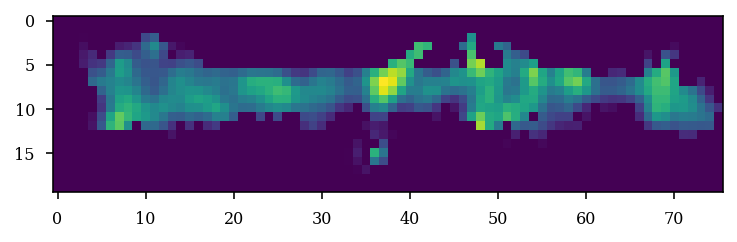

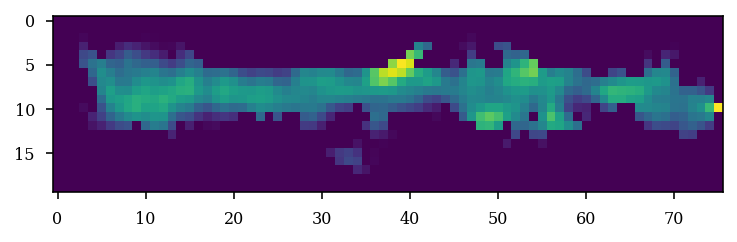

In [123]:
plt.imshow(spatial_maps.tc.ratemap[60].T)
plt.show()
plt.imshow(spatial_maps.tc.ratemap[90].T)

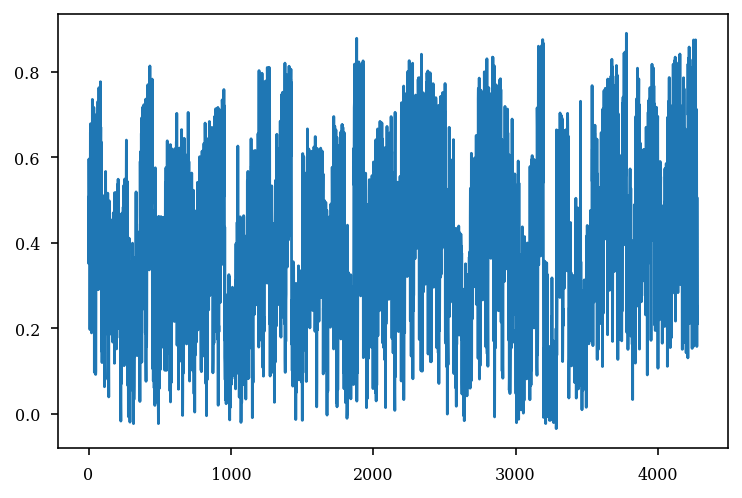

In [115]:
plt.plot(spatial_corr)

In [ ]:
for ratemap in spatial_maps.tc.ratemap:
    ratemap[spatial_maps.tc.occupancy <= 0] = np.nan

    plt.imshow(ratemap.T,interpolation="nearest",vmax=np.nanmax(ratemap)*.8)
    plt.axis("equal")
    plt.colorbar(extend="max")
    plt.show()

In [15]:
1/np.diff(position_df.time.values).min()

39.06250000009104

In [16]:
position_df.sr.iloc[0]

39.0625

In [173]:
basepath = r"Z:\Data\FujisawaS\EE\EE0708fm"
results = pairwise_ccgs.run(basepath)


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide


In [174]:
results["label_df"]

,corr_pearson,pval_pearson,corr_spearman,pval_spearman,spatial_corr,spatial_info_ref,spatial_info_tar,peak_rate_ref,peak_rate_tar,n_spikes_ref,...,deepSuperficial_target,ref_UID,target_UID,ref_region,target_region,ref_id,target_id,epoch,environment,basepath
0,-0.008569,0.855209,-0.008569,0.855209,NaN,NaN,NaN,NaN,NaN,3,...,Deep,41,302,PFC,CA1,0,71,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
1,-0.012060,0.797302,-0.013378,0.775713,NaN,NaN,NaN,NaN,NaN,3,...,Deep,41,305,PFC,CA1,0,73,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
2,-0.026078,0.578589,-0.031000,0.509049,NaN,NaN,NaN,NaN,NaN,3,...,Deep,41,306,PFC,CA1,0,74,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
3,-0.022721,0.628445,-0.024867,0.596367,NaN,NaN,NaN,NaN,NaN,3,...,Superficial,41,307,PFC,CA1,0,75,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
4,-0.009397,0.841391,-0.009397,0.841391,NaN,NaN,NaN,NaN,NaN,3,...,Deep,41,308,PFC,CA1,0,76,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5665,-0.033066,0.043933,-0.040230,0.014223,NaN,NaN,NaN,NaN,NaN,30,...,Deep,295,358,PFC,CA1,69,97,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
5666,0.010726,0.513513,0.000816,0.960340,NaN,NaN,NaN,NaN,NaN,30,...,Deep,295,359,PFC,CA1,69,98,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
5667,-0.004555,0.781434,-0.011028,0.501710,NaN,NaN,NaN,NaN,NaN,30,...,Deep,295,361,PFC,CA1,69,99,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
5668,0.047573,0.003738,0.024155,0.141125,NaN,NaN,NaN,NaN,NaN,30,...,Deep,295,362,PFC,CA1,69,100,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm


In [165]:
spatial_maps.tc.ratemap.max(axis=1).shape

(93, 20)

In [171]:
st.n_spikes

array([ 40826,  10296,  11837,   5229,  46969,   7462,   6335,  21338,
         5678,  19974,  15592,   7108,   7901,   6485,  25328,  26910,
        24807,   2314,   6211,   9734,  17040,   8474,  13347,  34142,
        12661,  25922,  32589,  16373,  32748,  22361,  15915,   3942,
         9498,  12589,   7098,   2919,   4803,  86100,  24238,  58010,
        13900,   9188,  10605,   8752,  18266,  48765,   3139,   4379,
        35202,  44514,  23322,   4595,  22488,  13526,   7968,  27405,
        50262,  38893,  13830,  62152,  28355,  21509,  10139,  32165,
        60204,  28112,  19404,  25283,  21770,   9898,  14858,  13699,
        13080,   6133,  60183,  12091,  47588,   6507,  14830,   9345,
        18692,  22045,  12464,  54454,  47909,  58961,  43408,  22011,
        13854,   5169, 120630,  21933,  24522])

In [168]:
peak_rate = [np.nanmax(x) for x in spatial_maps.tc.ratemap][0]
peak_rate

4.477446289326349

<AxesSubplot:>

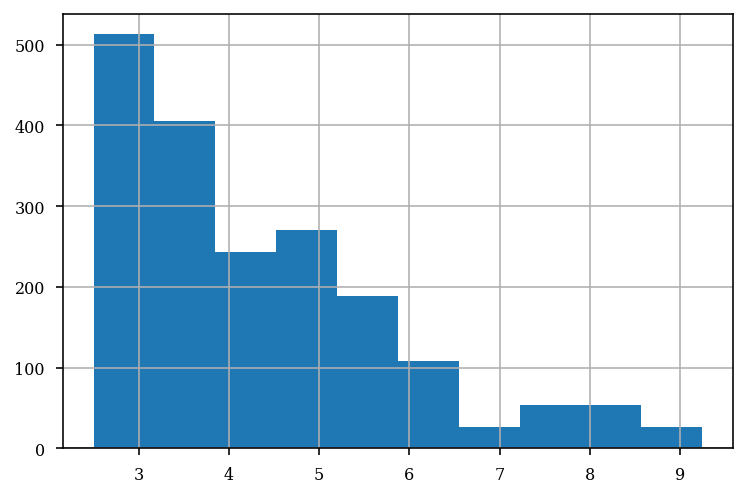

In [212]:
results["label_df"].query("epoch == 'task'").spatial_info_ref.hist()

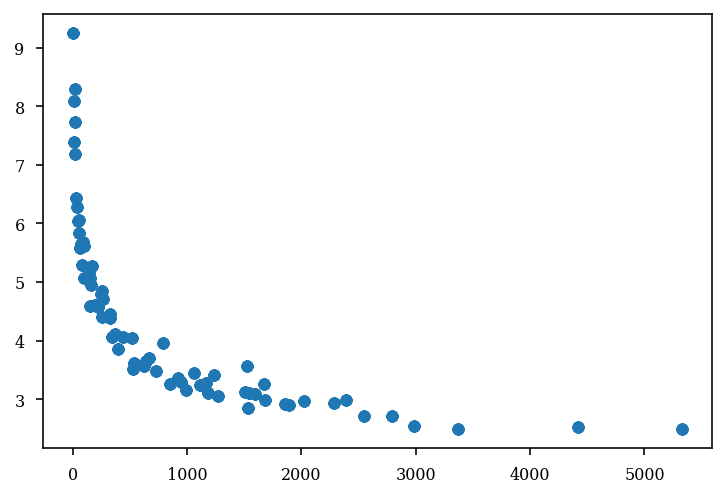

In [233]:
plt.scatter(results["label_df"].n_spikes_ref, results["label_df"].spatial_info_ref)

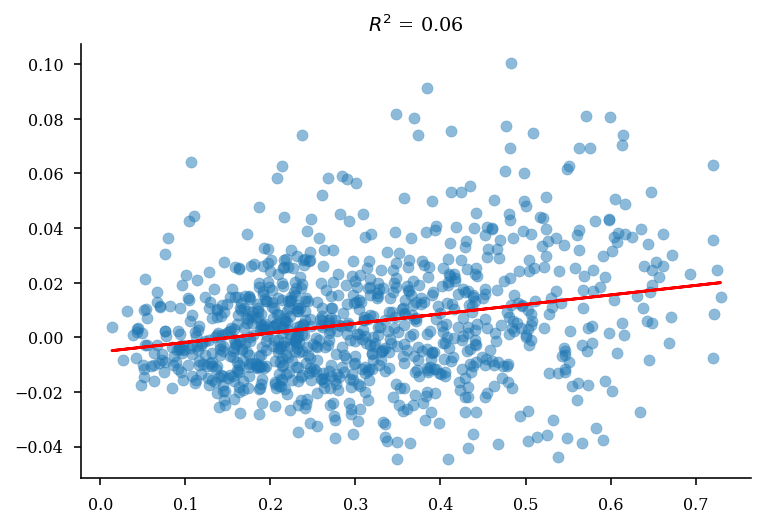

In [228]:
from sklearn.linear_model import LinearRegression

idx = (
    (results["label_df"].query("epoch == 'task'").peak_rate_ref.values > 1)
    & (results["label_df"].query("epoch == 'task'").peak_rate_tar.values > 1)
    & (results["label_df"].query("epoch == 'task'").n_spikes_ref.values > 100)
    & (results["label_df"].query("epoch == 'task'").n_spikes_tar.values > 100)
    & (results["label_df"].query("epoch == 'post'").n_spikes_ref.values > 100)
    & (results["label_df"].query("epoch == 'post'").n_spikes_tar.values > 100)
)
X, y = (
    results["label_df"].query("epoch == 'task'").spatial_corr[idx].values,
    results["label_df"].query("epoch == 'task'").corr_pearson[idx].values,
)
reg = LinearRegression().fit(X.reshape(-1, 1), y)
plt.scatter(X, y, alpha=0.5)
plt.plot(X,reg.coef_*X + reg.intercept_, color="r")
plt.title(F"$R^2$ = {reg.score(X.reshape(-1, 1),y):.2f}")
sns.despine()

<AxesSubplot:xlabel='epoch', ylabel='corr_spearman'>

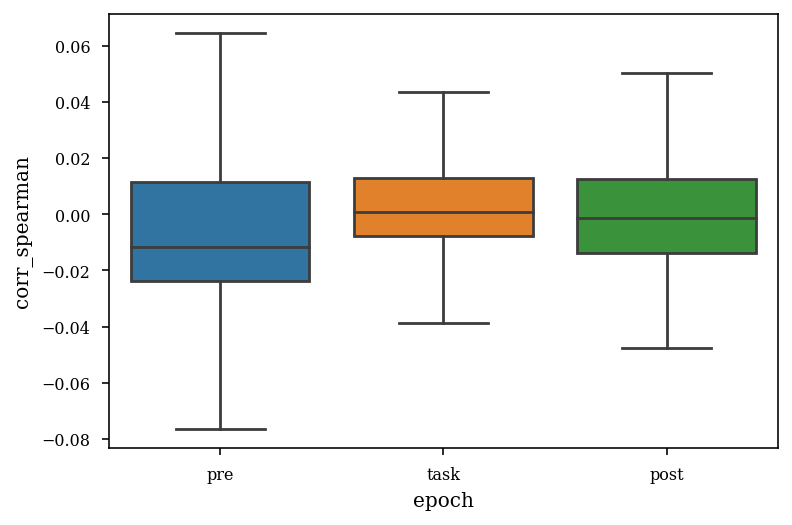

In [158]:
sns.boxplot(data=results["label_df"], x="epoch", y="corr_spearman",showfliers=False)
# sns.stripplot(data=results["label_df"], x="epoch", y="corr_spearman",jitter=True)

In [181]:
label_df = results["label_df"]

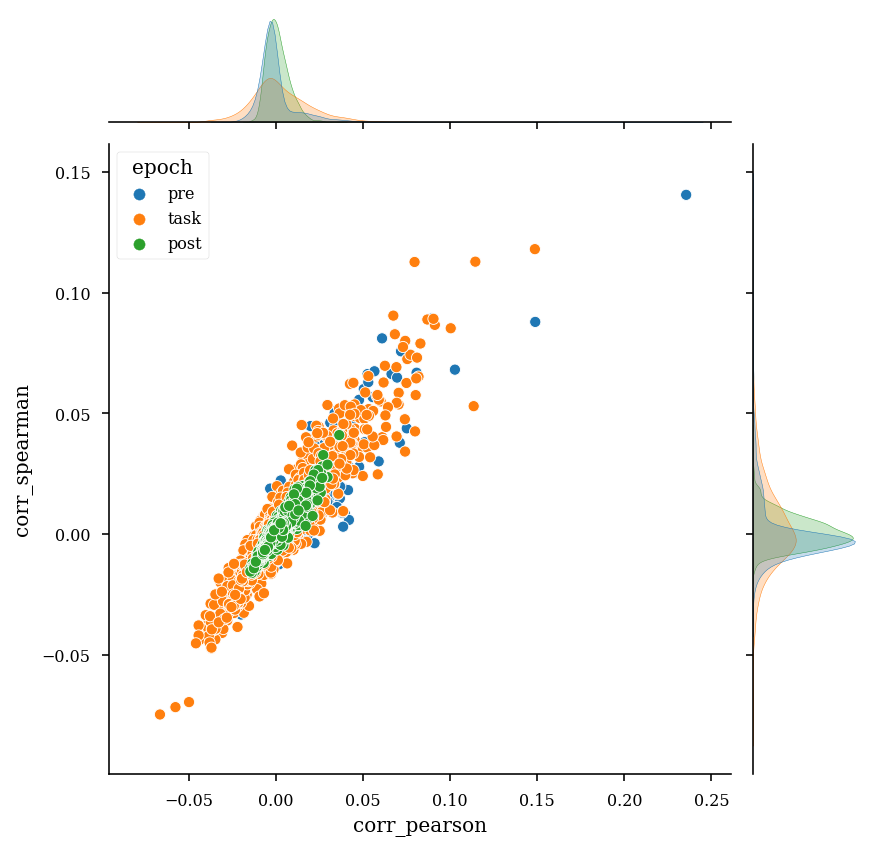

In [131]:
# sns.scatterplot(x="corr_pearson",y="corr_spearman",hue="epoch",data=results["label_df"])
# add unity line
# plt.plot([-1, 1], [-1, 1], color="black")

g = sns.jointplot(
    x="corr_pearson",y="corr_spearman",hue="epoch",data=results["label_df"],
    kind="scatter",
)

In [236]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccgs_readout_v5"
    )

batch_analysis.run(
    df_sessions,
    save_path,
    pairwise_ccgs.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
label_df, ccgs = pairwise_ccgs.load_results(save_path)

100%|██████████| 110/110 [00:09<00:00, 12.19it/s]


In [140]:
ccgs


""


In [183]:
label_df.query("epoch == 'pre'")


,corr_pearson,pval_pearson,corr_spearman,pval_spearman,deepSuperficial_ref,deepSuperficial_target,ref_UID,target_UID,ref_region,target_region,ref_id,target_id,epoch,environment,basepath
0,0.064386,5.323489e-07,0.043304,0.000750,Cortical,Deep,41,302,PFC,CA1,0,71,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
1,-0.006293,6.244130e-01,-0.007406,0.564515,Cortical,Deep,41,305,PFC,CA1,0,73,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
2,-0.011882,3.552656e-01,-0.015003,0.243103,Cortical,Deep,41,306,PFC,CA1,0,74,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
3,-0.011473,3.720826e-01,-0.014740,0.251458,Cortical,Superficial,41,307,PFC,CA1,0,75,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
4,-0.002879,8.227744e-01,-0.003434,0.789363,Cortical,Deep,41,308,PFC,CA1,0,76,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,-0.006802,5.966957e-01,-0.007909,0.538332,Cortical,Deep,295,358,PFC,CA1,69,97,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
1886,0.003874,7.631002e-01,-0.002094,0.870594,Cortical,Deep,295,359,PFC,CA1,69,98,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
1887,-0.006607,6.072369e-01,-0.007909,0.538332,Cortical,Deep,295,361,PFC,CA1,69,99,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm
1888,-0.013018,3.111608e-01,-0.015246,0.235563,Cortical,Deep,295,362,PFC,CA1,69,100,pre,sleep,Z:\Data\FujisawaS\EE\EE0708fm


In [184]:
label_df.query("epoch == 'task'")

,corr_pearson,pval_pearson,corr_spearman,pval_spearman,deepSuperficial_ref,deepSuperficial_target,ref_UID,target_UID,ref_region,target_region,ref_id,target_id,epoch,environment,basepath
1890,-0.010752,0.269782,-0.013222,0.174752,Cortical,Deep,41,302,PFC,CA1,0,71,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm
1891,-0.019257,0.048092,-0.021157,0.029882,Cortical,Deep,41,305,PFC,CA1,0,73,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm
1892,0.023340,0.016583,0.013763,0.157769,Cortical,Deep,41,306,PFC,CA1,0,74,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm
1893,-0.004847,0.618875,-0.004782,0.623553,Cortical,Superficial,41,307,PFC,CA1,0,75,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm
1894,0.001040,0.915018,0.012236,0.209175,Cortical,Deep,41,308,PFC,CA1,0,76,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3775,-0.024066,0.013501,-0.012285,0.207346,Cortical,Deep,295,358,PFC,CA1,69,97,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm
3776,0.009208,0.344623,0.004050,0.677633,Cortical,Deep,295,359,PFC,CA1,69,98,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm
3777,-0.003408,0.726494,-0.006318,0.516688,Cortical,Deep,295,361,PFC,CA1,69,99,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm
3778,-0.010471,0.282514,-0.008344,0.391772,Cortical,Deep,295,362,PFC,CA1,69,100,task,tmaze,Z:\Data\FujisawaS\EE\EE0708fm


In [185]:
label_df.query("epoch == 'post'")


,corr_pearson,pval_pearson,corr_spearman,pval_spearman,deepSuperficial_ref,deepSuperficial_target,ref_UID,target_UID,ref_region,target_region,ref_id,target_id,epoch,environment,basepath
3780,0.001742,0.676753,-0.002724,0.514375,Cortical,Deep,41,302,PFC,CA1,0,71,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
3781,-0.005604,0.179808,-0.007351,0.078470,Cortical,Deep,41,305,PFC,CA1,0,73,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
3782,0.000578,0.889946,-0.004334,0.299573,Cortical,Deep,41,306,PFC,CA1,0,74,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
3783,0.006968,0.095331,0.000948,0.820472,Cortical,Superficial,41,307,PFC,CA1,0,75,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
3784,0.002161,0.604924,-0.002831,0.498047,Cortical,Deep,41,308,PFC,CA1,0,76,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5665,-0.003524,0.398902,0.000535,0.898056,Cortical,Deep,295,358,PFC,CA1,69,97,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
5666,-0.003384,0.417922,0.000632,0.879797,Cortical,Deep,295,359,PFC,CA1,69,98,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
5667,0.005696,0.172751,0.006051,0.147521,Cortical,Deep,295,361,PFC,CA1,69,99,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm
5668,0.011790,0.004768,0.003715,0.373856,Cortical,Deep,295,362,PFC,CA1,69,100,post,sleep,Z:\Data\FujisawaS\EE\EE0708fm


In [133]:
from scipy.ndimage import gaussian_filter1d


def plot_psth_matrix(
    psth_df, label=None, ax=None, vmax=3, vmin=-3,smoothing=True
):

    psth = psth_df.values
    
    psth = psth[:,~np.isnan(psth).any(axis=0)]
    if smoothing:
        psth_smooth = gaussian_filter1d(
            psth, np.round(0.020 / np.diff(psth_df.index)[0]), axis=0
        )
    else:
        psth_smooth = psth
    # psth_smooth = psth
    max_mean_ratio = psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1), :].max(
        axis=0
    ) / psth_smooth[(psth_df.index < -0.10), :].mean(axis=0)

    sort_idx = np.argsort(max_mean_ratio)

    if ax is None:
        plt.figure()
    ax = plt.gca()

    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0)[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr",
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm
    
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

def get_center_val(psth_df, window=[0,0.05], smooth_sigma=0.02):
    # find cells within region
    psth = psth_df.values
    # standardize psth
    psth = stats.zscore(psth, axis=0)
    # smooth over time
    psth_smooth = gaussian_filter1d(
        psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
    )
    # pull out data within time window
    X = psth_smooth[(psth_df.index > window[0]) & (psth_df.index < window[1]), :]
    # find center value of each cell, can be positive or negative, but will be max magnitude
    center_val = [X[np.argmax(np.abs(X[:,i])),i] for i in range(X.shape[1])]
    return np.array(center_val)

def plot_psth_postive_negative(psth_df, group_label, group_colors, ax0):

    center_val = get_center_val(psth_df)

    # plot positive psth responses
    psth = psth_df.values
    psth = psth[:,center_val > 0]
    psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)

    # plot negative psth responses
    psth = psth_df.values
    psth = psth[:,center_val < 0]
    psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)



In [186]:
label_df.loc[label_df.target_region.str.contains("PFC|MEC"),"deepSuperficial_target"] = "Unknown"
label_df.loc[label_df.ref_region.str.contains("PFC|MEC"),"deepSuperficial_ref"] = "Unknown"

label_df["label"] = label_df.ref_region + "_" + label_df.target_region
label_df["label"] = label_df.label.replace({"MEC_CA1":"CA1_MEC", "PFC_CA1":"CA1_PFC"})

label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_ref == "Deep"),"label"] = "deep_mec"
label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_ref == "Superficial"),"label"] = "sup_mec"

label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_target == "Deep"),"label"] = "deep_mec"
label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_target == "Superficial"),"label"] = "sup_mec"


label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_ref == "Deep"),"label"] = "deep_pfc"
label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_ref == "Superficial"),"label"] = "sup_pfc"

label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_target == "Deep"),"label"] = "deep_pfc"
label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_target == "Superficial"),"label"] = "sup_pfc"

label_df.label.unique()

array(['deep_pfc', 'sup_pfc'], dtype=object)

In [96]:
# label_df.query("label == 'CA1_CA1'")[["deepSuperficial_ref","deepSuperficial_target"]].value_counts()

In [138]:
ccgs[label_df.label=="deep_mec"]

""


In [139]:
ccgs

""


IndexError: index 0 is out of bounds for axis 0 with size 0

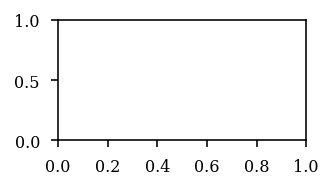

In [135]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
ccgs_restrict = ccgs.loc[(ccgs.index >=-.2) & (ccgs.index <=.2),:]

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(4,2)),constrained_layout=False)
gs = fig.add_gridspec(nrows=5, ncols=2, left=0.05, right=0.75, hspace=0.4, wspace=0.4)

y_min = -.75
y_max = 1.25
heatmap_factor = 2

ax0 = fig.add_subplot(gs[0, 0])
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="deep_mec"], 'deep_mec', group_colors, ax0)
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="sup_mec"], 'sup_mec', group_colors, ax0)


ax1 = fig.add_subplot(gs[0, 1])
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="deep_pfc"], 'deep_pfc', group_colors, ax1)
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="sup_pfc"], 'sup_pfc', group_colors, ax1)


ax2 = fig.add_subplot(gs[1:3,0])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="deep_mec"], label=None, ax=ax2, vmax=3, vmin=-3)


ax3 = fig.add_subplot(gs[1:3,1])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="deep_pfc"], label=None, ax=ax3, vmax=3, vmin=-3)


ax4 = fig.add_subplot(gs[3:,0])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="sup_mec"], label=None, ax=ax4, vmax=3, vmin=-3)

ax5 = fig.add_subplot(gs[3:,1])
sm = plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="sup_pfc"], label=None, ax=ax5, vmax=3, vmin=-3)

# axs = [ax0,ax1,ax2,ax3,ax4,ax5]
# for i in range(6):
#     axs[i].set_xlim([-0.2,.2])

## testing below

In [12]:
basepath = r"Z:\Data\AYAold\AYA7\day20"
brainRegions="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC"  # brain regions to include

# load in spike data
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion=brainRegions
)

In [34]:
rip_exp_start=0.2
rip_exp_stop=0.2
ripples_df = loading.load_ripples_events(basepath)
ripples = (
    nel.EpochArray(np.array([ripples_df.peaks, ripples_df.peaks]).T)
    .expand(rip_exp_start, direction="start")
    .expand(rip_exp_stop, direction="stop")
)

In [23]:
binsize=0.005
nbins=200

In [35]:
ccgs, pairs = functions.pairwise_cross_corr(
    st[ripples].data, return_index=True, binsize=binsize, nbins=nbins
)

<AxesSubplot:>

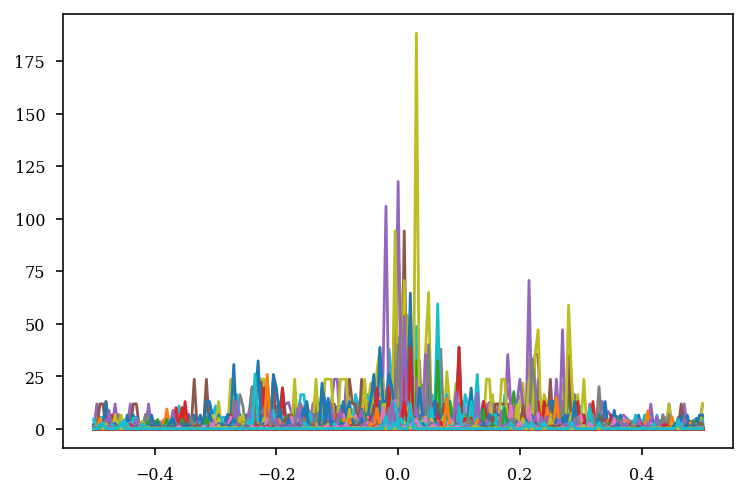

In [36]:
ccgs.plot(legend=False)